In [ ]:
#Below are all the external libraries used in this notebook, they don't require  any pip installation if run from a colab notebook.
#Later on I will be using Xgboost with a GPU. If you want to run the training , you will need to enable "GPU Acceleration" (Edit->Notebook Settings->Hardware Acceleration) or remove " tree_method='gpu_hist' "
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import imblearn
import xgboost as xgb
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

In [ ]:
from google.colab import files 
uploaded = files.upload() #Upload the case study csv file

Saving case_study_data.csv to case_study_data.csv


**There are different components to revenue optimization (such as price optimization, which I don't think is doable with this dataset) .**

**The approach I am proposing here, is training a machine learning model to identify searchs that are more likely to result in a booking, in order to increase conversion rate, thus the problem will be framed as a binary classification task.** 

**Now let's load the dataset in a pandas dataframe.**

In [ ]:
hotel_data=pd.read_csv('case_study_data.csv')

In [ ]:
hotel_data.head() #Look at the 5 first rows

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,20150126,20160402,20160416,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,NaN,NaN,NaN
1,20150126,20160402,20160416,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,NaN,NaN,NaN
2,20150126,20160402,20160416,3,2,0,29771,1905.54,1,25.826343,52.0,13,1,1,0,NaN,NaN,NaN
3,20150126,20160403,20160408,2,0,1,517,2077.95,0,64.490309,85.0,9,0,0,0,NaN,NaN,NaN
4,20150126,20160403,20160408,2,0,1,40744,6822.10,0,24.959968,52.0,11,1,2,0,NaN,NaN,NaN


In [ ]:
hotel_data.describe() # Stats about our variables, we can see that the minimum hotel_price is negative, surely an error , we will remove outliers later.

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,Unnamed: 15,Unnamed: 16,Unnamed: 17
count,4.664900e+04,4.664900e+04,4.664900e+04,46649.000000,46649.000000,46649.000000,46649.000000,46649.000000,46649.000000,45447.000000,46324.000000,46649.000000,46649.000000,46649.000000,46649.000000,0.0,0.0,0.0
mean,2.015011e+07,2.015055e+07,2.015059e+07,2.370555,0.812322,5509.415593,23095.173787,2598.923857,0.501468,76.849181,63.109598,59.071256,5.982315,2.357521,0.006624,NaN,NaN,NaN
std,7.336832e+00,8.698793e+02,9.527680e+02,0.912651,0.949211,4460.736102,13480.380598,4490.042057,0.500003,41.747154,22.846002,51.380975,6.014717,1.811254,0.081118,NaN,NaN,NaN
min,2.015010e+07,2.015010e+07,2.015010e+07,1.000000,0.000000,0.000000,1.000000,-1058.820000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,2.015011e+07,2.015022e+07,2.015022e+07,2.000000,0.000000,1656.000000,11474.000000,559.400000,0.000000,46.238512,52.000000,16.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN
50%,2.015011e+07,2.015042e+07,2.015043e+07,2.000000,0.000000,4488.000000,23309.000000,1336.580000,1.000000,67.712628,52.000000,46.000000,4.000000,1.000000,0.000000,NaN,NaN,NaN
75%,2.015012e+07,2.015071e+07,2.015072e+07,3.000000,2.000000,8727.000000,33668.000000,3090.510000,1.000000,128.117134,90.000000,86.000000,9.000000,4.000000,0.000000,NaN,NaN,NaN
max,2.015013e+07,2.016051e+07,2.016052e+07,8.000000,6.000000,16015.000000,46647.000000,175454.410000,1.000000,143.777606,100.000000,287.000000,36.000000,7.000000,1.000000,NaN,NaN,NaN


In [ ]:
hotel_data.info() # hotel_feature1 and hotel_feature2 have missing values, and the last 3 columns are empty, all variables are numeric.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46649 entries, 0 to 46648
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   search_date      46649 non-null  int64  
 1   arrival          46649 non-null  int64  
 2   departure        46649 non-null  int64  
 3   num_adults       46649 non-null  int64  
 4   num_children     46649 non-null  int64  
 5   search_id        46649 non-null  int64  
 6   hotel_id         46649 non-null  int64  
 7   hotel_price      46649 non-null  float64
 8   is_promo         46649 non-null  int64  
 9   hotel_feature_1  45447 non-null  float64
 10  hotel_feature_2  46324 non-null  float64
 11  hotel_feature_3  46649 non-null  int64  
 12  hotel_feature_4  46649 non-null  int64  
 13  hotel_feature_5  46649 non-null  int64  
 14  booked           46649 non-null  int64  
 15  Unnamed: 15      0 non-null      float64
 16  Unnamed: 16      0 non-null      float64
 17  Unnamed: 17 

In [ ]:
hotel_data=hotel_data.drop(columns=['Unnamed: 15','Unnamed: 16','Unnamed: 17']) #Dropping the empty columns

In [ ]:
hotel_data.duplicated().value_counts() #Find how many rows are duplicates

False    40926
True      5723
dtype: int64

In [ ]:
hotel_data=hotel_data.drop_duplicates() #Drop the duplicated rows

In [ ]:
hotel_data=hotel_data.dropna() #Remove rows with missing values, since the dataset is big enough and most missing values are on rows where booked=0.

In [ ]:
hotel_data[['search_date','arrival','departure']]=hotel_data[['search_date','arrival','departure']].apply(pd.to_datetime,format='%Y%m%d') ### Format all dates from int to date type

In [ ]:
hotel_data.head()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked
0,2015-01-26,2016-04-02,2016-04-16,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0
2,2015-01-26,2016-04-02,2016-04-16,3,2,0,29771,1905.54,1,25.826343,52.0,13,1,1,0
3,2015-01-26,2016-04-03,2016-04-08,2,0,1,517,2077.95,0,64.490309,85.0,9,0,0,0
4,2015-01-26,2016-04-03,2016-04-08,2,0,1,40744,6822.10,0,24.959968,52.0,11,1,2,0
5,2015-01-26,2016-04-03,2016-04-08,2,0,1,19030,2906.65,0,59.219929,55.0,5,0,1,0


In [ ]:
print(hotel_data['booked'].value_counts()) 
print(hotel_data['booked'].value_counts(normalize=True)) #the booked variable (our target variable) is heavily imbalanced, this is to be expected as few searchs will actually result in a booking 

0    39281
1      284
Name: booked, dtype: int64
0    0.992822
1    0.007178
Name: booked, dtype: float64


In [ ]:
hotel_data['departure'].max()-hotel_data['search_date'].min()

Timedelta('501 days 00:00:00')

In [ ]:
hotel_data['search_date'].max()-hotel_data['search_date'].min()

Timedelta('25 days 00:00:00')

Because the biggest time gap in the dataset is only 501 days (between earliest search, and latest departure) and all searchs are within 25 days, I will make the assumption that this is too much of a small time frame for any possible trends and/or seasonabilty to matter ( eg : more bookings over the years, more bookings during summer etc..). 

So intead of encoding dates as variables, i'll introduce 2 numeric variables to replace the 3 dates variables. 

1.   length_of_stay = departure - arrival
2.   days_in_advance = arrival - search_date



In [ ]:
hotel_data['length_of_stay']=(hotel_data['departure']-hotel_data['arrival']).dt.days
hotel_data['days_in_advance']=(hotel_data['arrival']-hotel_data['search_date']).dt.days

In [ ]:
hotel_data=hotel_data.drop(columns=['search_date','arrival','departure']) #remove dates 

In [ ]:
hotel_data.head()

,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,length_of_stay,days_in_advance
0,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,14,432
2,3,2,0,29771,1905.54,1,25.826343,52.0,13,1,1,0,14,432
3,2,0,1,517,2077.95,0,64.490309,85.0,9,0,0,0,5,433
4,2,0,1,40744,6822.10,0,24.959968,52.0,11,1,2,0,5,433
5,2,0,1,19030,2906.65,0,59.219929,55.0,5,0,1,0,5,433


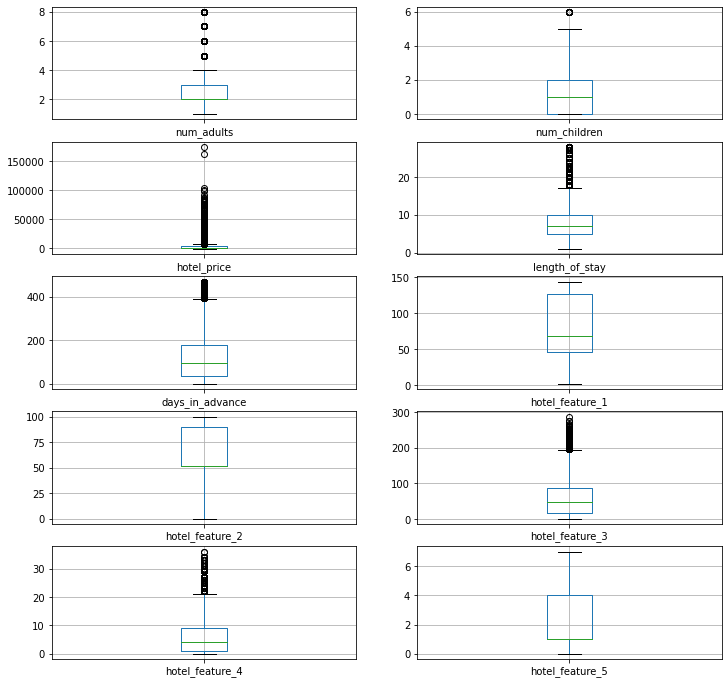

In [ ]:
#Boxplots of numerical variables

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=[12,12])

hotel_data.boxplot('num_adults',ax=axes[0,0]) 
hotel_data.boxplot('num_children',ax=axes[0,1])
hotel_data.boxplot('hotel_price',ax=axes[1,0])
hotel_data.boxplot('length_of_stay',ax=axes[1,1]) 
hotel_data.boxplot('days_in_advance',ax=axes[2,0])
hotel_data.boxplot('hotel_feature_1',ax=axes[2,1])
hotel_data.boxplot('hotel_feature_2',ax=axes[3,0])
hotel_data.boxplot('hotel_feature_3',ax=axes[3,1])
hotel_data.boxplot('hotel_feature_4',ax=axes[4,0])
hotel_data.boxplot('hotel_feature_5',ax=axes[4,1])


hotel_price seems to have a lot of outliers, let's remove some of them (top and bottom 1% ) I won't remove outliers from other variables as there aren't many of them and Xgboost is robust to outliers.

In [ ]:
q_low = hotel_data["hotel_price"].quantile(0.01)
q_hi  = hotel_data["hotel_price"].quantile(0.99)

hotel_data = hotel_data[(hotel_data["hotel_price"] < q_hi) & (hotel_data["hotel_price"] > q_low)] #only keep rows that have hotel price below the 99 percentile and above the 1 percentile

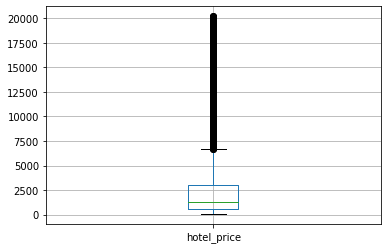

In [ ]:
hotel_data.boxplot('hotel_price')

I will also add two variables that I think could have predictive power ,and since we will use a decision tree based algorithm we don't have to worry about multicollinearity.

1.   price_per_people = hotel_price/(num_adults+num_children)
2.   price_per_day = hotel_price/(length_of_stay)



In [ ]:
hotel_data["price_per_people"] = hotel_data['hotel_price']/(hotel_data['num_adults']+hotel_data['num_children']) #Adding new features
hotel_data["price_per_day"] = hotel_data['hotel_price']/hotel_data['length_of_stay']

In [ ]:
hotel_data=hotel_data.drop(columns=['search_id','hotel_id']) #dropping search_id and hotel_id

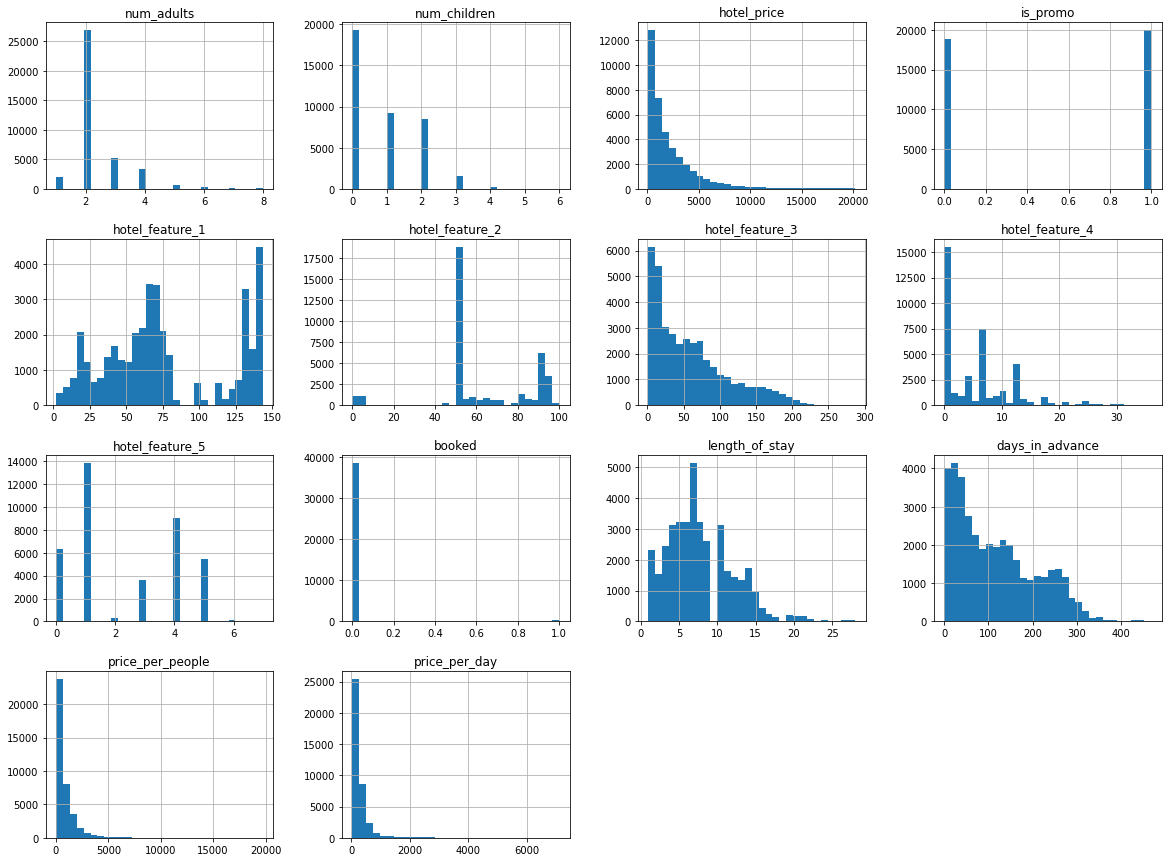

In [ ]:
hotel_data.hist(bins=30, figsize=(20,15))
plt.show()

Most variables are skewed and have very different scales. But since we will be using Xgboost we don't need to transform them.

As said earlier our target variable is heavily imbalanced, to try to address that I will make use of 


* Random undersampling : a percentage of the negative class will be randomly dropped during training.
* Oversampling using SMOTE : new synthetic exemples of the positive class will be created during training.
* Weighted class : the positive class will have added weight during training ,false negatives will be penalized more.   




In [ ]:
y=hotel_data['booked'].to_numpy() #let's separate the target variable from our features

In [ ]:
hotel_data=hotel_data.drop(columns=['booked']) 
X=hotel_data.to_numpy()

In [ ]:
oversample = SMOTE(sampling_strategy=0.2) #will add 20% synthethic positive examples
undersample = RandomUnderSampler(sampling_strategy=0.5)#will remove 50% of negative examples


In [ ]:
#let's create our xgboost classifier
#binary:logistic means it will output a probability rather than the predicted class, which is good since we want to detect searchs that are more likely to make a booking
#I will make use of random search to find the best hyperparameters , hence why parameters have multiple values.
model = xgb.XGBClassifier(objective='binary:logistic',silent=True,early_stopping_rounds=400,tree_method='gpu_hist')
params = {
        'm__n_estimators': stats.randint(2000, 6000),
        'm__learning_rate': [0.02,0.06,0.07,0.08],
        'm__min_child_weight': [1,2,3,4,5],
        'm__gamma': [0.25,0.50,0.75,1],
        'm__subsample': [0.6, 0.8, 1.0],
        'm__colsample_bytree': [0.6, 0.8, 1.0],
        'm__max_depth': [4,5,6,7],
        'm__reg_alpha':[0.25,0.50,0.75,1],
        'm__reg_lambda':[0.25,0.50,0.75,1],
        'm__scale_pos_weight': [10,25,50],
        'm__max_delta_step' : [1,5,8,10] 

        }

In [ ]:
pipeline = Pipeline(steps=[('o', oversample), ('u', undersample),('m', model)])
folds = 5 #number of folds for Kfold cross validation
param_comb =5 #number of candidates  to try for random search
skf = StratifiedKFold(n_splits=folds, shuffle = True)
random_search = RandomizedSearchCV(pipeline, param_distributions=params,refit='average_precision',
                                   n_iter=param_comb,scoring=['average_precision','roc_auc','recall'], 
                                   cv = skf.split(X,y),verbose=3,random_state=42)

#average_precision is equivalent to aucpr : Area Under Curve Precision-Recall.
#I choose this metric because our target variable is imbalanced, metrics like accuracy or logloss will be missleading.
#Precision = TP/(TP+FP) , Recall = TP/(TP+FN) 
#TN(true negatives) which will consitute the vast majority of predictions doesn't appear in any of these equations hence why AUCPR won't inflate the metric (quite the contrary)

In [ ]:
random_search.fit(X, y) #Start the training


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0, average_precision=0.053, recall=0.091, roc_auc=0.640, total=  27.0s
[CV] m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.0s remaining:    0.0s


[CV]  m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0, average_precision=0.028, recall=0.109, roc_auc=0.688, total=  26.7s
[CV] m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.7s remaining:    0.0s


[CV]  m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0, average_precision=0.056, recall=0.125, roc_auc=0.668, total=  26.7s
[CV] m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0 
[CV]  m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0.5, m__scale_pos_weight=50, m__subsample=1.0, average_precision=0.033, recall=0.107, roc_auc=0.725, total=  26.8s
[CV] m__colsample_bytree=1.0, m__gamma=1, m__learning_rate=0.02, m__max_delta_step=8, m__max_depth=6, m__min_child_weight=5, m__n_estimators=5092, m__reg_alpha=0.75, m__reg_lambda=0

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  9.7min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7ff3c1eec4c0>,
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('o',
                                              SMOTE(k_neighbors=5,
                                                    kind='deprecated',
                                                    m_neighbors='deprecated',
                                                    n_jobs=1,
                                                    out_step='deprecated',
                                                    random_state=None,
                                                    ratio=None,
                                                    sampling_strategy=0.2,
                                                    svm_estimator='deprecated')),
                                             ('u',
                                              RandomUnderSampler(random_state=None,
     

In [ ]:
random_search.best_estimator_.named_steps["m"].get_booster().feature_names= list(hotel_data.columns) #get feature names from our dataframe

In [ ]:
print(random_search.best_estimator_) #best combinaison of hyperparameters
print("aucpr :", random_search.best_score_) #best score

Pipeline(memory=None,
         steps=[('o',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy=0.2, svm_estimator='deprecated')),
                ('u',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.5)),
                ('m',
                 XGBClassifier(base_sco...
                               colsample_bytree=1.0, early_stopping_rounds=400,
                               gamma=0.75, learning_rate=0.07, max_delta_step=5,
                               max_depth=7, min_child_weight=4, missing=None,
                               n_estimators=4747, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
      

Unfortunately the predictive power of the model isn't good in and of itself (around 0.04 aucpr) but it's still better than random guessing as over 99,28% of our dataset was made of the negative class , a random classifier would have an aucpr of 0.007, so in theory it should still be useful to increase profit.


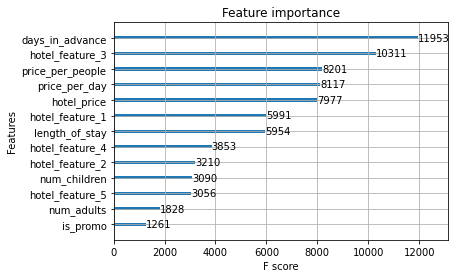

In [ ]:
xgb.plot_importance(random_search.best_estimator_.named_steps['m'].get_booster()) #Let's plot the feature importances
plt.show()

**According to our model "hotel_feature_3" and "days_in_advance" are the most 
important features for making a decision.
Surprisingly the least important feature by far is "is_promo" this could be because most of its effect is captured indirectly by prices features. Or the promotions are not too effective in increasing the conversion rate.**


---


**Feature importance doesn't tell us exactly how and in what way the feature influence the decision. It could be a complex rule involving the other variables, but it might still be a good way to gain business insight.**


---


**Now that we have our model that can assign each search, a probability of converting, how do we use that to increase revenue ?**

**One way could be to use the model to find the searchs that were the most likely to convert but didn't, and combine that with a dynamic pricing strategy (offer them a discount  , rather than offering a discount to those that would have converted anyway, and to those who won't convert no matter what)**
